**Aknowledgement:** Creating custom dataset and data loaders based on code segments from
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**Instructions:** Run all cells up to and including the cell just below the section that says **"Training"** to train the model.  To make predictions, run the cell that says **"Make Predictions"**.

In [1]:
!pip install kaggle
!echo '{"username":"stevenchungpy","key":"ee9da023f4ab98ede96402b617cb2d4d"}' > kaggle.json
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c cs-480-2024-spring
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

!pip install torchmetrics
from torchmetrics.regression import R2Score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 5.4 MB/s eta 0:00:00


In [3]:
plants_df = pd.read_csv('data/train.csv')

n = 65
img_name = f"{plants_df.iloc[n, 0]}.jpeg"
plants = plants_df.iloc[n, 1:]
plants = np.asarray(plants, dtype=float).reshape(-1, 169)

print('Image name: {}'.format(img_name))
print('Plants shape: {}'.format(plants.shape))

Image name: 15673271.jpeg
Plants shape: (1, 169)


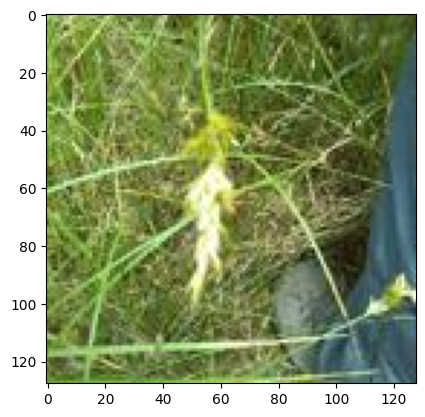

In [4]:
def show_plant(image):
    """Show image"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_plant(io.imread(os.path.join('data/train_images/', img_name)))
plt.show()


In [5]:
COLS = ["X4_mean", "X11_mean", "X18_mean", "X26_mean", "X50_mean", "X3112_mean"]

def remove_outliers(df, cols=None):
    if not cols:
        cols = df.columns[1:]

    df_subset = df[cols]

    mean = df_subset.mean()
    std = df_subset.std()
    lb, ub = mean - 3*std, mean + 3*std
    df_subset = df_subset[(lb <= df_subset) & (df_subset <= ub)]
    df[cols] = df_subset
    return df.dropna()


def pre_process_targets(df):
    df_subset = df[["X4_mean", "X11_mean", "X18_mean", "X26_mean", "X50_mean", "X3112_mean"]]

    # Log-10 of targets
    df_subset = np.log10(df_subset)

    # Normalize targets
    df_subset = (df_subset - df_subset.min())/(df_subset.max() - df_subset.min())
    df[["X4_mean", "X11_mean", "X18_mean", "X26_mean", "X50_mean", "X3112_mean"]] = df_subset
    return df

class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, indices=None, image_transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with ancillary data.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.plants_df = pd.read_csv(csv_file)
        if indices is not None:
            self.plants_df = self.plants_df[self.plants_df.index.isin(indices)]

        self.plants_df = pre_process_targets(self.plants_df)
        self.plants_df = remove_outliers(self.plants_df, COLS)

        self.root_dir = root_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.plants_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.plants_df.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, f"{img_id}.jpeg")
        image = io.imread(img_name)
        plants = self.plants_df.iloc[idx, 1:]
        plants = torch.tensor(np.array(plants, dtype='float'))

        if self.image_transform:
            image = self.image_transform(image)

        sample = {'img_id': img_id, 'image': image, 'plants': plants}

        return sample

0 (128, 128, 3) torch.Size([169])


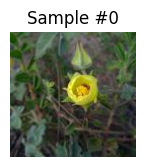

1 (128, 128, 3) torch.Size([169])


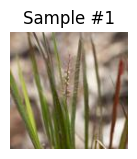

2 (128, 128, 3) torch.Size([169])


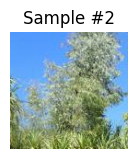

3 (128, 128, 3) torch.Size([169])


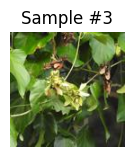

In [6]:
plants_dataset = PlantsDataset(csv_file='data/train.csv', root_dir='data/train_images/')

fig = plt.figure()

for i, sample in enumerate(plants_dataset):
    print(i, sample['image'].shape, sample['plants'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_plant(sample['image'])

    if i == 3:
        plt.show()
        break

In [7]:
# plants_dataset = PlantsDataset(csv_file='data/train.csv', root_dir='data/train_images/', image_transform = transforms.ToTensor(), plants_transform = transforms.ToTensor())

# images_arr = [0]*len(plants_dataset)
# plants_arr = [0]*len(plants_dataset)

# for i, sample in enumerate(plants_dataset):
#     if i % 2000 == 0:
#         print(i)
#     image, plants = sample['image'], sample['plants'][0][-6:]
#     images_arr[i] = image
#     plants_arr[i] = plants

# images_arr = torch.tensor(np.array(images_arr))
# plants_arr = torch.tensor(np.array(plants_arr))

# mean_channel1, mean_channel2, mean_channel3 = np.array(torch.mean(images_arr, axis=(0,2,3)))
# std_channel1, std_channel2, std_channel3 = np.array(torch.std(images_arr, axis=(0,2,3)))

# mean_feat1, mean_feat2, mean_feat3, mean_feat4, mean_feat5, mean_feat6 = np.array(torch.mean(plants_arr, axis=0))
# std_feat1, std_feat2, std_feat3, std_feat4, std_feat5, std_feat6 = np.array(torch.std(plants_arr, axis=0))

# print(mean_channel1, mean_channel2, mean_channel3)
# print(std_channel1, std_channel2, std_channel3)
# print(mean_feat1, mean_feat2, mean_feat3, mean_feat4, mean_feat5, mean_feat6)
# print(std_feat1, std_feat2, std_feat3, std_feat4, std_feat5, std_feat6)

In [8]:
image_means = (0.446368, 0.45045814, 0.33603808)
image_stds = (0.047683284, 0.043622777, 0.04787104)

plants_means = [1.0362410717771533, 148.31737552439125, 19701.645040781925, 3481.911812478604, 15.112066622155758, 399120.5983622429]
plants_stds = [0.018859793684877356, 47.85154635214786, 18.579760140378575, 4502.242094559821, 0.35188541328111456, 5084883.776221344]

train_df = pd.read_csv("data/train.csv")
train_indices = np.random.choice(train_df.index, size=int(0.9*len(train_df)), replace=False)

transformed_dataset = PlantsDataset(csv_file = 'data/train.csv',
                                    root_dir = 'data/train_images/',
                                    indices = train_indices,
                                    image_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(image_means, image_stds)
                                    ]))

0 torch.Size([256, 3, 128, 128]) torch.Size([256, 169])
1 torch.Size([256, 3, 128, 128]) torch.Size([256, 169])
2 torch.Size([256, 3, 128, 128]) torch.Size([256, 169])


3 torch.Size([256, 3, 128, 128]) torch.Size([256, 169])


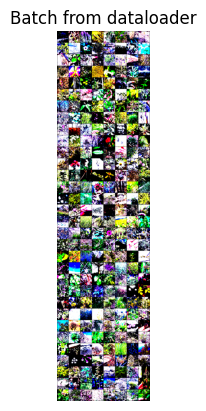

In [9]:
BATCH_SIZE = 256
training_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

def show_plants_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch, plants_batch = \
            sample_batched['image'], sample_batched['plants']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(training_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['plants'].size())

    if i_batch == 3:
        plt.figure()
        show_plants_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [10]:
import torch.nn as nn
from torchvision import models

class Network_CNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.model_name='resnet18'
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class Network_NN(nn.Module):
    def __init__(self, input_size=163, output_size=6):
        super().__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

In [12]:
# Compute R2 Score between predictions and targets
def compute_R2(predictions, targets):
    r2score = R2Score(num_outputs = 6, multioutput = 'raw_values')
    return r2score(predictions, targets)

In [13]:
def train(network_CNN, network_NN, training_loader, optimizer, loss_fn):
    network_CNN.train()
    network_NN.train()
    print(len(training_loader))
    # running_R2_scores = []
    # running_R2_score = 0
    # running_losses = []
    # running_loss = 0
    for i, minibatch_data in enumerate(training_loader):
        if i % 10 == 0:
            print("Minibatch number: {}".format(i+1))
        inputs_image = minibatch_data['image']

        plants = minibatch_data['plants'].float()
        inputs_plants = plants[:, :-6]
        values = plants[:, -6:]

        optimizer.zero_grad()

        # Forward pass
        outputs_CNN = network_CNN(inputs_image)
        outputs_NN = network_NN(inputs_plants)

        outputs = (outputs_CNN + outputs_NN)/2

        # Compute the loss and its gradients
        loss = loss_fn(outputs, values)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        R2_score = compute_R2(outputs, values)
        # running_R2_score += R2_score
        # running_loss += loss.item()

        if i % 10 == 0:
            print(f"Loss = {loss.item():.4f}, Average R2 = {torch.mean(R2_score)}, R2 = {R2_score.tolist()}")

        # if i % 10 == 0:
        #     running_R2_scores.append(running_R2_score)
        #     running_losses.append(running_loss)
        #     running_R2_score = 0
        #     running_loss = 0

    #return running_R2_scores, running_losses

In [14]:
df = pd.read_csv("data/train.csv")
df[COLS] = np.log10(df[COLS])
MINs = torch.tensor(df[COLS].min())
RANGEs = torch.tensor(df[COLS].max() - df[COLS].min())

class testPlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, image_transform=None):
        self.plants_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.plants_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.plants_df.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, f"{img_id}.jpeg")
        image = io.imread(img_name)

        plants = self.plants_df.iloc[idx, 1:]
        plants = torch.tensor(np.array(plants, dtype='float'))

        if self.image_transform:
            image = self.image_transform(image)

        return {'img_id': img_id, 'image': image, 'plants': plants}

def test(network_CNN, network_NN, validation_loader, loss_fn, calculate_R2=False):
    img_ids = []
    outputs_lst = []
    with torch.no_grad():
        print(len(validation_loader))
        running_R2_score = 0
        running_loss = 0
        for i, validation_data in enumerate(validation_loader):
            print("Validation number: {}".format(i+1))

            img_id = validation_data['img_id']
            inputs_image = validation_data['image']

            plants = validation_data['plants'].float()

            if calculate_R2:
                inputs_plants = plants[:, :-6]
                values = plants[:, -6:]
            else:
                inputs_plants = plants

            outputs_CNN = network_CNN(inputs_image)
            outputs_NN = network_NN(inputs_plants)
            outputs = (outputs_CNN + outputs_NN) / 2

            if calculate_R2:
                R2_score = compute_R2(outputs, values)
                running_R2_score += R2_score
                loss = loss_fn(outputs, values)
                running_loss += loss.item()

            outputs = 10**((outputs * RANGEs) + MINs)

            img_ids.append(img_id)
            outputs_lst.append(outputs)

    if calculate_R2:
        final_R2_score = running_R2_score / len(validation_loader)
        final_loss = running_loss / len(validation_loader)
        print(f"Final R2 score: {final_R2_score}, Final loss: {final_loss}")
        return img_ids, outputs_lst, final_R2_score, final_loss
    else:
        return img_ids, outputs_lst

<ipython-input-14-1685af846303>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MINs = torch.tensor(df[COLS].min())
<ipython-input-14-1685af846303>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  RANGEs = torch.tensor(df[COLS].max() - df[COLS].min())


**Training**
---

In [25]:
k = 5 # k-fold cross validation
BATCH_SIZE = 256

train_df = pd.read_csv("data/train.csv")
inds = np.random.choice(train_df.index, size=len(train_df), replace=False)
inds_split = np.array_split(inds, k)

final_train_losses = []
final_train_R2_scores = []
final_test_losses = []
final_test_R2_scores = []
for validation_inds in inds_split[:1]:
    train_inds = train_df[~train_df.index.isin(validation_inds)].index

    transformed_dataset = PlantsDataset(csv_file = 'data/train.csv',
                                    root_dir = 'data/train_images/',
                                    indices = train_inds,
                                    image_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(image_means, image_stds)
                                    ]))
    training_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    validation_transformed_dataset = PlantsDataset(csv_file = 'data/train.csv',
                                               root_dir = 'data/train_images/',
                                               indices = validation_inds,
                                               image_transform = transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(image_means, image_stds)
                                               ]))
    validation_loader = DataLoader(validation_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    net_CNN = Network_CNN()
    net_NN = Network_NN()

    EPOCHS = 3
    LR = 0.01
    MOMENTUM = 0.9
    WEIGHT_DECAY = 1e-5

    loss_fn = nn.MSELoss()
    #optimizer = torch.optim.SGD(list(net_CNN.parameters()) + list(net_NN.parameters()), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    optimizer = torch.optim.Adam(list(net_CNN.parameters()) + list(net_NN.parameters()), weight_decay=WEIGHT_DECAY)

    # train_running_R2_scores_lst = []
    # train_running_losses_lst = []

    #train_R2_scores = []
    #train_losses = []
    test_R2_scores = []
    test_losses = []
    for epoch in range(1, EPOCHS+1):
        print("EPOCH {}:".format(epoch))

        # running_R2_scores, running_losses = train(net_CNN, net_NN, training_loader, optimizer, loss_fn)
        # train_running_R2_scores_lst.append(running_R2_scores)
        # train_running_losses_lst.append(running_losses)
        train(net_CNN, net_NN, training_loader, optimizer, loss_fn)

        #img_ids, outputs_lst, final_R2_score, final_loss = test(net_CNN, net_NN, training_loader, loss_fn, calculate_R2=True)
        #train_R2_scores.append(final_R2_score)
        #train_losses.append(final_loss)

        img_ids, outputs_lst, final_R2_score, final_loss = test(net_CNN, net_NN, validation_loader, loss_fn, calculate_R2=True)
        test_R2_scores.append(final_R2_score)
        test_losses.append(final_loss)

    #final_train_R2_scores.append(train_R2_scores[-1])
    #final_train_losses.append(train_losses[-1])
    final_test_R2_scores.append(test_R2_scores[-1])
    final_test_losses.append(test_losses[-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 1:
124
Minibatch number: 1
Loss = 0.0850, Average R2 = -11.132916450500488, R2 = [-26.197391510009766, -0.711559534072876, -5.622757911682129, -28.128055572509766, -1.5304539203643799, -4.607279300689697]
Minibatch number: 11
Loss = 0.0202, Average R2 = -0.659040629863739, R2 = [-3.9317307472229004, 0.05067688226699829, -0.03330636024475098, -0.02545905113220215, 0.012369990348815918, -0.02679455280303955]
Minibatch number: 21
Loss = 0.0169, Average R2 = -0.29715225100517273, R2 = [-1.8470633029937744, 0.005906343460083008, 0.006680905818939209, -0.011004447937011719, 0.00945216417312622, 0.053115010261535645]
Minibatch number: 31
Loss = 0.0147, Average R2 = -0.12091481685638428, R2 = [-1.109560489654541, 0.08138453960418701, 0.11038577556610107, 0.04723292589187622, 0.05427718162536621, 0.09079116582870483]
Minibatch number: 41
Loss = 0.0143, Average R2 = -0.1042376458644867, R2 = [-0.9621251821517944, 0.05954897403717041, 0.13144654035568237, 0.017018437385559082, 0.08321952819

**Make Predictions**
---

In [26]:
test_transformed_dataset = testPlantsDataset(csv_file = 'data/test.csv',
                                             root_dir = 'data/test_images/',
                                             image_transform = transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(image_means, image_stds)
                                             ]))

testing_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

img_ids, outputs_lst = test(net_CNN, net_NN, testing_loader, loss_fn, calculate_R2=False)
img_ids, outputs_lst = torch.cat(img_ids), torch.cat(outputs_lst)

25
Validation number: 1
Validation number: 2
Validation number: 3
Validation number: 4
Validation number: 5
Validation number: 6
Validation number: 7
Validation number: 8
Validation number: 9
Validation number: 10
Validation number: 11
Validation number: 12
Validation number: 13
Validation number: 14
Validation number: 15
Validation number: 16
Validation number: 17
Validation number: 18
Validation number: 19
Validation number: 20
Validation number: 21
Validation number: 22
Validation number: 23
Validation number: 24
Validation number: 25


In [27]:
# Output predictions as csv
new_df = pd.DataFrame(outputs_lst, columns = COLS)
new_df.insert(0, 'id', img_ids)
new_df.to_csv("results_5_5_CNN_NN_Adam_MSE.csv", index=False)

**Show R2 Scores and loss**
---

In [28]:
print(final_test_losses)
print(final_test_R2_scores)

[0.012689846928321546]
[tensor([-0.0534,  0.1145,  0.2740,  0.0393,  0.0479,  0.1822])]


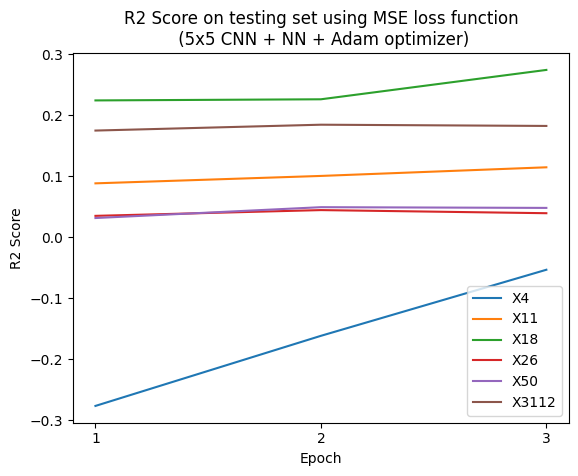

In [38]:
another_df = pd.DataFrame(np.array(test_R2_scores), columns=["X4", "X11", "X18", "X26", "X50", "X3112"])
another_df["Epoch"] = [1,2,3]

another_df.plot(x="Epoch")
plt.title("R2 Score on testing set using MSE loss function\n (5x5 CNN + NN + Adam optimizer)")
plt.xticks([1, 2, 3])
plt.xlabel("Epoch")

plt.ylabel("R2 Score")
plt.show()